In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib
import logging
import os
import nevergrad as ng
from concurrent import futures
import time
import networkx as nx
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
import sklearn.svm as svm
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

logger = logging.getLogger(__name__)
logging.basicConfig(level=os.environ.get("LOGLEVEL", "WARNING"))

from common import *
from helpers import *

RK Toolkit 0.0.1b


In [2]:
df = make_df_from_sheet(r"data/GWTC_2021_Master.csv") # read the file
df.head(n=1)

,id (Event ID),commonName (Event Name),Classification,version,catalog.shortName,GPS,Mass_1_source (solar masses),mass_1_source_upper_error,Mass_1_Upper Limit (solar masses),mass_1_source_lower_error,...,redshift_upper_limit,far,far_lower,far_upper,p_astro,p_astro_lower,p_astro_upper,final_mass_source,final_mass_source_lower,final_mass_source_upper
0,GW150914-v3,GW150914,Black Hole (High Mass),3,GWTC-1-confident,1126259462,35.6,4.7,40.3,-3.1,...,0.12,1.000000e-07,NaN,NaN,1.0,NaN,NaN,63.1,-3.0,3.4


In [3]:
def filter_bh(df): 
    # returns indexes of bh items
    return df.Classification.str.contains("Black Hole")

def filter_ns(df):
    return df.Classification.str.contains("Neutron Star")

/Users/akmb2/miniforge3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1061: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


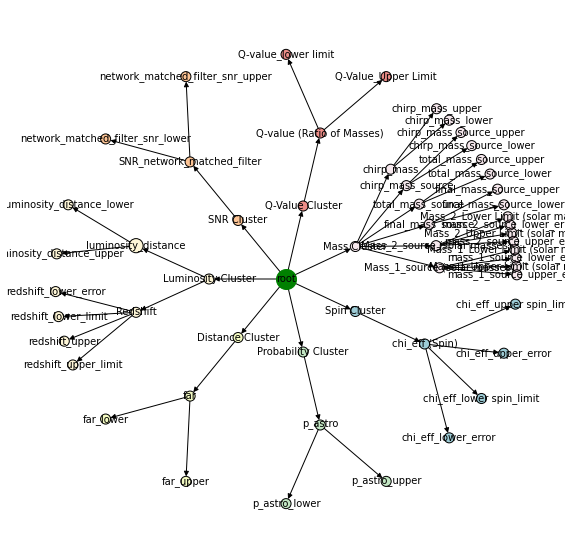

In [4]:
# load the heirarchy file.
from rktoolkit.functions.htg_transformers import BaseOntologyTransform
from rktoolkit.visualizers.util import draw_graph

hierarchy_file = r'data/gwtc_heirarchy_pretty.json'
hft = BaseOntologyTransform(mapping=json.load(open(hierarchy_file, "r")))
processed_df, y, alldf, ids = preprocess(df)

# plot the heirarchy
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
g = hft.transform(processed_df.iloc[0])
draw_graph(g , ax=ax, with_labels=True, minsize=100, alpha=100, emult=2, make_axis=False) 
os.makedirs("rendered", exist_ok=True)
plt.savefig("rendered/heirarchy_graph.png")

In [5]:
opts = {
    "chi_eff (Spin)": [-0.1, 0.1],
    "Q-value (Ratio of Masses)": [.01, .88]
}
import numbers
from rktoolkit.functions.filters import RangeFilter
from rktoolkit.functions.linkers import SimpleChildLinker

def make_linkers_and_filters(graph, opts={}):
    '''
    Defaults all filters to be a range filter. And the linker to be a simple child linker. 
    '''
    ENDL = " | " 
    filters, linkers = {}, {}
    for k, v in graph.nodes.items():
        if 'value' in v and isinstance(v['value'], numbers.Number):
            if v["id"] in opts:
                print("Set {:s} from options".format(v["id"]), end=ENDL)
            else:
                print("Set {:s} to default".format(v["id"]), end=ENDL)
            minv, maxv = opts.get(v["id"][0], 0), opts.get(v["id"][1], 1)
            filters[k] = RangeFilter(min=minv, max=maxv)        
    linkers['root'] = SimpleChildLinker()
    return filters, linkers

filters, linkers = make_linkers_and_filters(g, opts)

Set Mass_1_source (solar masses) to default | Set mass_1_source_upper_error to default | Set Mass_1_Upper Limit (solar masses) to default | Set mass_1_source_lower_error to default | Set Mass_1_Lower Limit (solar masses) to default | Set mass_2_source_upper_error to default | Set final_mass_source to default | Set final_mass_source_lower to default | Set final_mass_source_upper to default | Set total_mass_source to default | Set total_mass_source_lower to default | Set total_mass_source_upper to default | Set chirp_mass_source to default | Set chirp_mass_source_lower to default | Set chirp_mass_source_upper to default | Set chirp_mass to default | Set chirp_mass_lower to default | Set chirp_mass_upper to default | Set Q-value (Ratio of Masses) from options | Set Q-Value_Upper Limit to default | Set Q-value_lower limit to default | Set SNR_network_matched_filter to default | Set network_matched_filter_snr_upper to default | Set network_matched_filter_snr_lower to default | Set luminosit

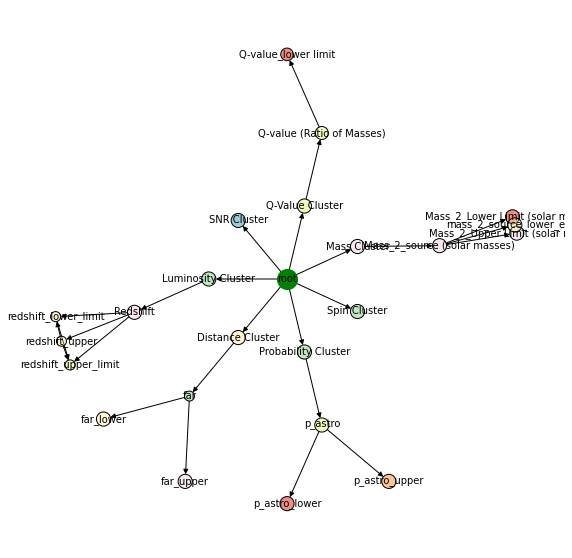

In [6]:
from rktoolkit.models.pipeline import RKPipeline 
from rktoolkit.visualizers.util import draw_rk_diagram
from rktoolkit.models.graph import Edge 

pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
g2 = pipeline.transform(g, is_base=False)
fig, ax = plt.subplots(figsize=(10,10))
draw_rk_diagram(g2, ax=ax, with_labels=True, minsize=100, alpha=100, emult=2, make_axis=False)  
plt.savefig("rendered/rk_graph1.png")

## Untuned Visualizations

Set Mass_1_source (solar masses) to default | Set mass_1_source_upper_error to default | Set Mass_1_Upper Limit (solar masses) to default | Set mass_1_source_lower_error to default | Set Mass_1_Lower Limit (solar masses) to default | Set mass_2_source_upper_error to default | Set final_mass_source to default | Set final_mass_source_lower to default | Set final_mass_source_upper to default | Set total_mass_source to default | Set total_mass_source_lower to default | Set total_mass_source_upper to default | Set chirp_mass_source to default | Set chirp_mass_source_lower to default | Set chirp_mass_source_upper to default | Set chirp_mass to default | Set chirp_mass_lower to default | Set chirp_mass_upper to default | Set Q-value (Ratio of Masses) to default | Set Q-Value_Upper Limit to default | Set Q-value_lower limit to default | Set SNR_network_matched_filter to default | Set network_matched_filter_snr_upper to default | Set network_matched_filter_snr_lower to default | Set luminosity_

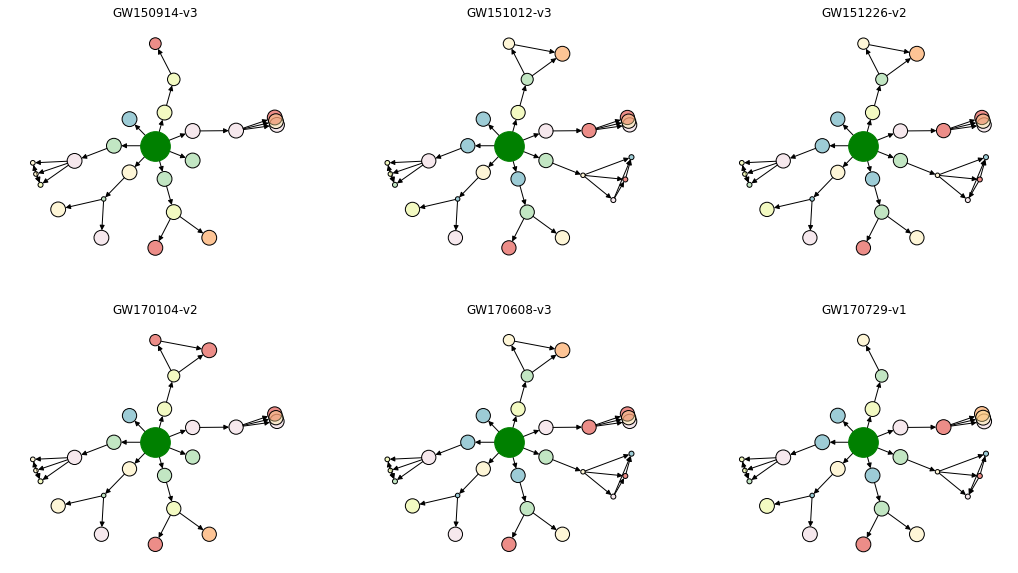

In [7]:
# completely untuned
f, l = make_linkers_and_filters(g, {})
n = 6
pipeline = RKPipeline(filter_map=f, linkage_map=l, structural_graph=g)
rkmodels = make_n_rkmodels(processed_df, alldf, hft, pipeline, n=n)
mdist = compute_distance(processed_df)
distances = compute_distances(rkmodels, mdist, w=[.5,.5])
visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
plt.savefig("rendered/untuned_{}.png".format(n))
print("Average similarity of graphs pre tuned: {}".format(1 - np.mean(distances)))

Average similarity of graphs pre tuned: 0.9305839375818552


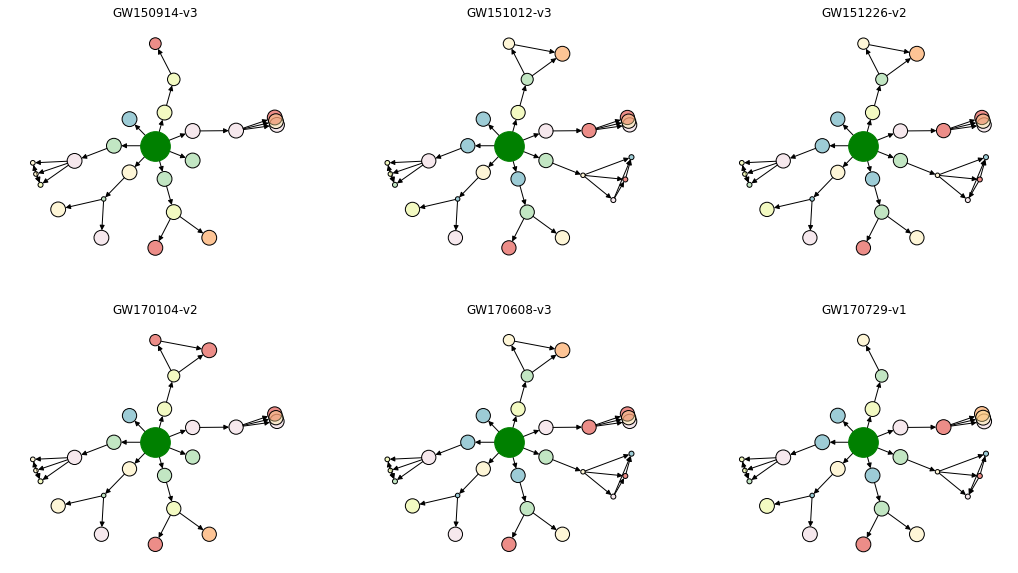

In [8]:
n = 6
pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
rkmodels = make_n_rkmodels(processed_df, alldf, hft, pipeline, n=n)
mdist = compute_distance(processed_df)
distances = compute_distances(rkmodels, mdist, w=[.5,.5])
visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
plt.savefig("rendered/untuned_{}.png".format(n))
print("Average similarity of graphs pre tuned: {}".format(1 - np.mean(distances)))

In [9]:
selected_events = ["GW170729", "GW170817", "GW190814", "GW190521"]
subset_df = df[df["commonName (Event Name)"].isin(selected_events)]
label_df = df.iloc[subset_df.index]

def build_4_model(pipeline, title, filename):
    n = 4
    rkmodels = make_n_rkmodels(processed_df, alldf,hft, pipeline, n=n, indexes=list(subset_df.index))
    print("Processed {} rk models from {}".format(len(rkmodels), len(processed_df)))
    mdist = compute_distance(processed_df)
    distances = compute_distances(rkmodels, mdist, w=[.5,.5])
    visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
    
    plt.savefig("rendered/untuned_{}_{}.png".format(filename, n))
    plt.show()
    print("Average similarity of graphs pre tuned: {}".format(1 - np.mean(distances)))
    

## Tuning

Iteration: 00100. Loss: 0.98205128. ITime 6.49 seconds. Total time: 6.60
Iteration: 00200. Loss: 0.90128078. ITime 6.62 seconds. Total time: 13.22
Iteration: 00300. Loss: 0.93921569. ITime 6.81 seconds. Total time: 20.03
Iteration: 00400. Loss: 0.90504472. ITime 8.21 seconds. Total time: 28.24
Iteration: 00500. Loss: 0.94708995. ITime 7.16 seconds. Total time: 35.40
Iteration: 00600. Loss: 0.92807018. ITime 7.06 seconds. Total time: 42.45
Iteration: 00700. Loss: 0.91920698. ITime 7.08 seconds. Total time: 49.53
Iteration: 00800. Loss: 0.89871958. ITime 7.67 seconds. Total time: 57.20
Iteration: 00900. Loss: 0.92911934. ITime 7.55 seconds. Total time: 64.75
Iteration: 01000. Loss: 0.89275671. ITime 7.40 seconds. Total time: 72.15
Iteration: 01100. Loss: 0.90635197. ITime 7.61 seconds. Total time: 79.76
Iteration: 01200. Loss: 0.87027037. ITime 7.46 seconds. Total time: 87.22
Iteration: 01300. Loss: 0.90417024. ITime 7.50 seconds. Total time: 94.71
Iteration: 01400. Loss: 0.86233372. ITi

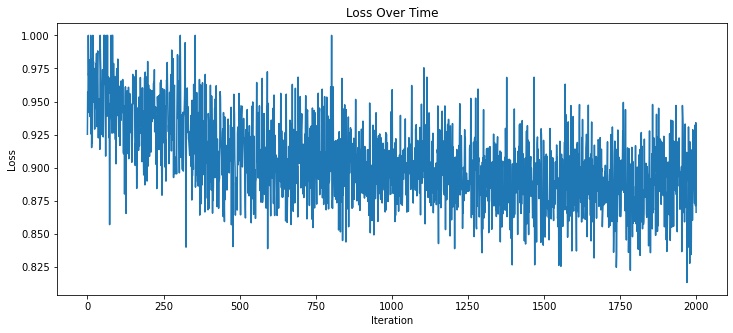

<Figure size 432x288 with 0 Axes>

In [10]:
w0 = pipeline.get_w()
weights, history = train(len(w0[0]), pipeline, processed_df, hft, mdist)
show(weights, history, pipeline, processed_df, hft, w0)

/Users/akmb2/miniforge3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1061: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


Average similarity of graphs tuned: 0.9305839375818552


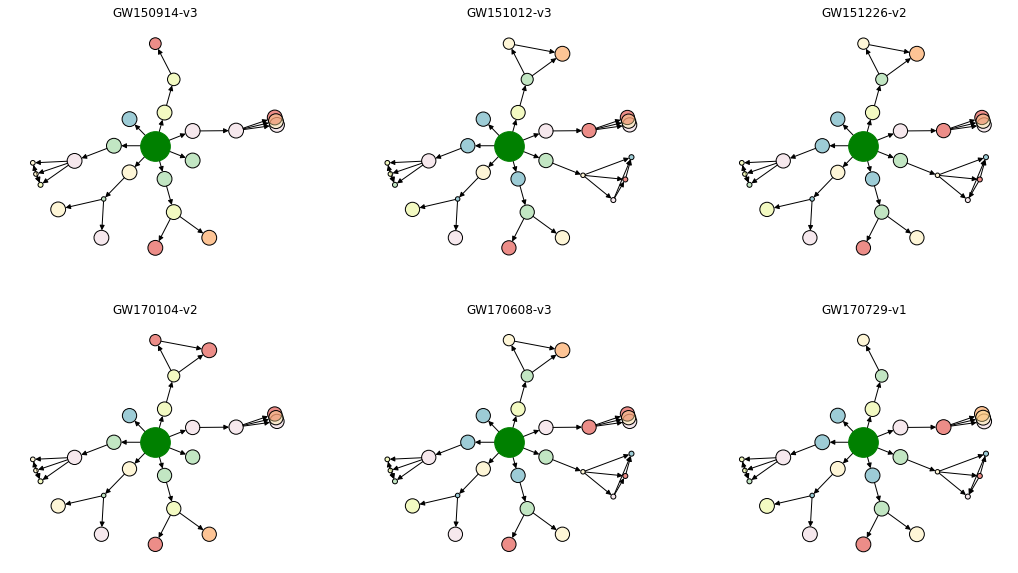

In [11]:
def run6(filters, linkers, g, processed_df, alldf, hft, pipeline):
    n = 6
    pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
    rkmodels = make_n_rkmodels(processed_df, alldf, hft, pipeline, n=n)
    mdist = compute_distance(processed_df)
    distances = compute_distances(rkmodels, mdist, w=[.5,.5])
    visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
    plt.savefig("rendered/untuned_{}.png".format(n))
    print("Average similarity of graphs tuned: {}".format(1 - np.mean(distances)))
    
run6(filters, linkers, g, processed_df, alldf, hft, pipeline)

### Classification

In [12]:
def build_classification_data(processed_df, y, alldf, hft, pipeline):
    n = len(processed_df)

    start = time.time()
    rkmodels = make_n_rkmodels(processed_df, alldf, hft, pipeline, n=n)
    t = time.time() - start
    print("Making rk models. Took {} seconds. {} seconds Per model".format(t, t/n))

    start = time.time()
    X = [ extract_rk_features(rk) for rk in rkmodels ]
    t = time.time() - start
    print("Extracted features. Took {} seconds. {} seconds Per model".format(t, t/n))
    return train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

def classify1(X_train, X_test, y_train, y_test):
    
    encoder = LabelEncoder()
    y = encoder.fit_transform(y_train.str.strip())
    
    clf = OneVsRestClassifier(
        svm.SVC(kernel="linear", probability=True, random_state=1)
    )

    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)

    y_score = clf.fit(X_train, y_train).decision_function(X_test)
    print(classification_report(y_test, predicted, target_names=encoder.classes_))
X_train, X_test, y_train, y_test = build_classification_data(processed_df, y, alldf, hft, pipeline)
classify1(X_train, X_test, y_train, y_test)

Making rk models. Took 0.24642086029052734 seconds. 0.0027079215416541467 seconds Per model
Extracted features. Took 4.219285249710083 seconds. 0.04636577197483608 seconds Per model
                           precision    recall  f1-score   support

   Black Hole (High Mass)       0.70      0.89      0.78        18
    Black Hole (Low Mass)       0.40      0.29      0.33         7
             Neutron Star       0.00      0.00      0.00         1
Neutron Star + Black Hole       0.00      0.00      0.00         1
            PBH Candidate       0.00      0.00      0.00         1

                 accuracy                           0.64        28
                macro avg       0.22      0.23      0.22        28
             weighted avg       0.55      0.64      0.59        28



/Users/akmb2/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/akmb2/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/akmb2/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on subset Neutron Star
Set Mass_1_source (solar masses) to default | Set mass_1_source_upper_error to default | Set Mass_1_Upper Limit (solar masses) to default | Set mass_1_source_lower_error to default | Set Mass_1_Lower Limit (solar masses) to default | Set mass_2_source_upper_error to default | Set final_mass_source to default | Set final_mass_source_lower to default | Set final_mass_source_upper to default | Set total_mass_source to default | Set total_mass_source_lower to default | Set total_mass_source_upper to default | Set chirp_mass_source to default | Set chirp_mass_source_lower to default | Set chirp_mass_source_upper to default | Set chirp_mass to default | Set chirp_mass_lower to default | Set chirp_mass_upper to default | Set Q-value (Ratio of Masses) to default | Set Q-Value_Upper Limit to default | Set Q-value_lower limit to default | Set SNR_network_matched_filter to default | Set network_matched_filter_snr_upper to default | Set network_matched_filter_snr_low

/Users/akmb2/miniforge3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1061: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


Average similarity Untuned + No Domain Expertise : 0.8275136883484946
Processed 5 rk models from 5
Average similarity Untuned + Domain Expertise: 0.8275136883484946
Processed 5 rk models from 5
Average similarity Tuned + Domain Expertise: 0.7922355673809225
Working on subset Black Hole
Set Mass_1_source (solar masses) to default | Set mass_1_source_upper_error to default | Set Mass_1_Upper Limit (solar masses) to default | Set mass_1_source_lower_error to default | Set Mass_1_Lower Limit (solar masses) to default | Set mass_2_source_upper_error to default | Set final_mass_source to default | Set final_mass_source_lower to default | Set final_mass_source_upper to default | Set total_mass_source to default | Set total_mass_source_lower to default | Set total_mass_source_upper to default | Set chirp_mass_source to default | Set chirp_mass_source_lower to default | Set chirp_mass_source_upper to default | Set chirp_mass to default | Set chirp_mass_lower to default | Set chirp_mass_upper to

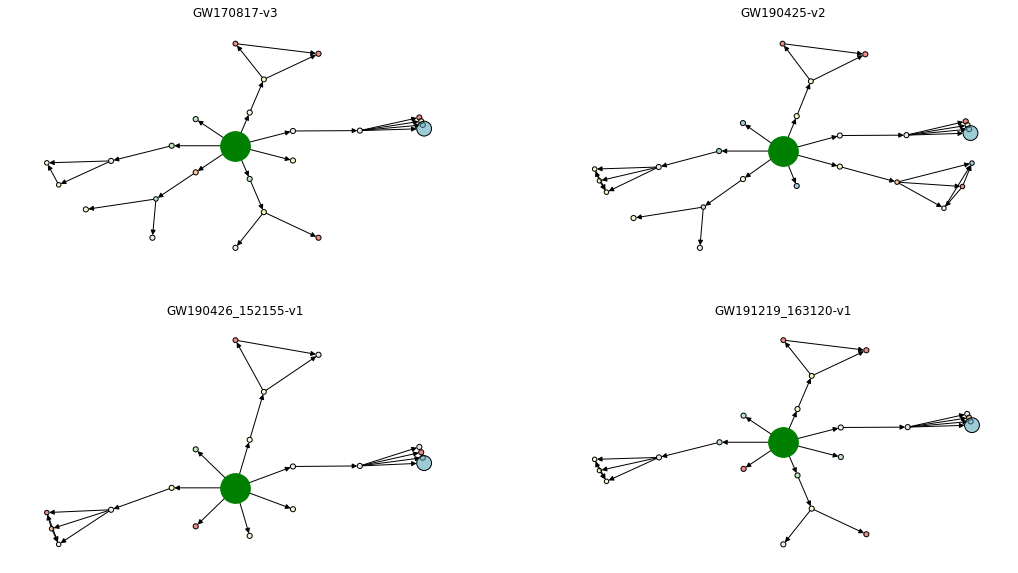

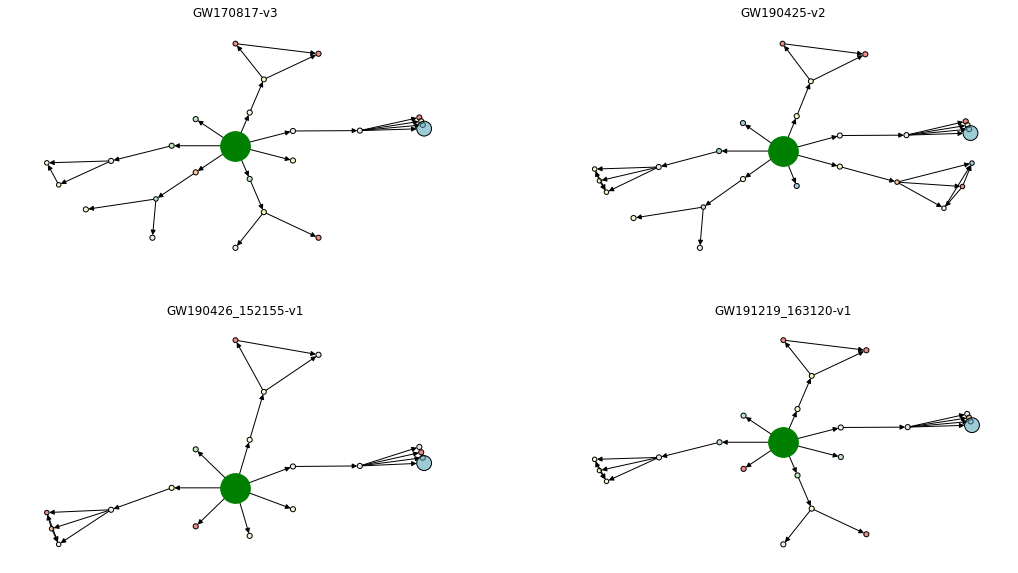

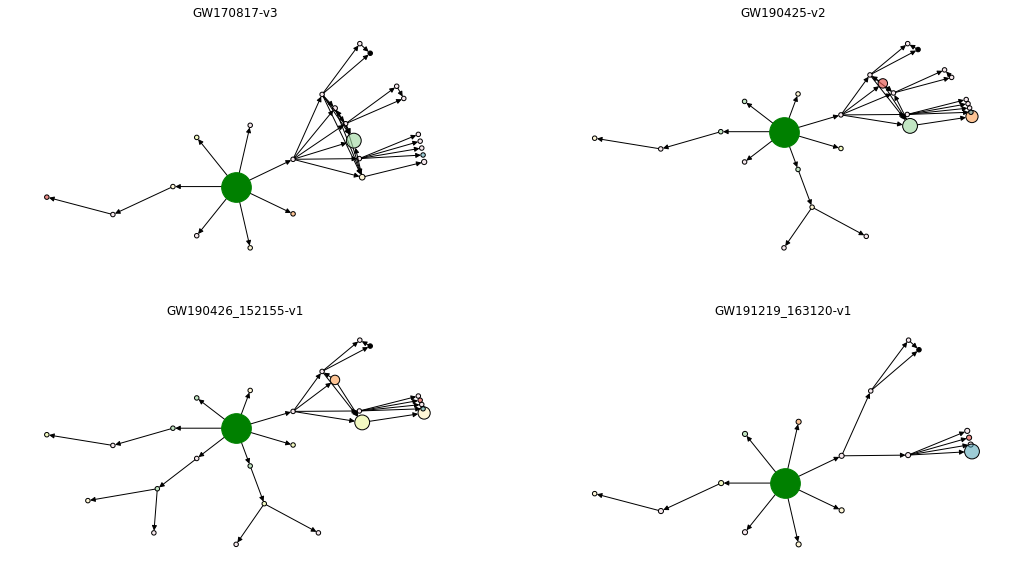

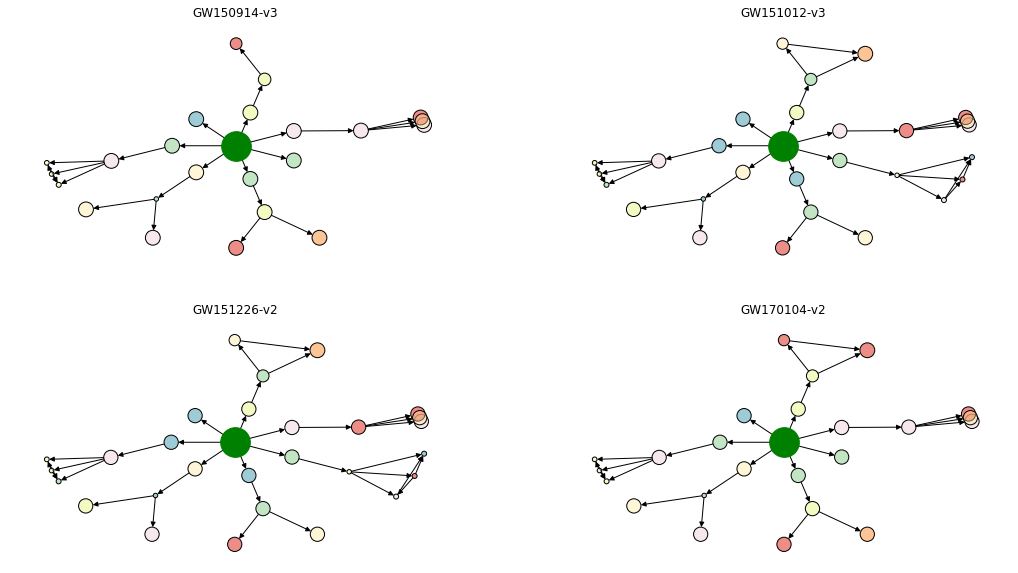

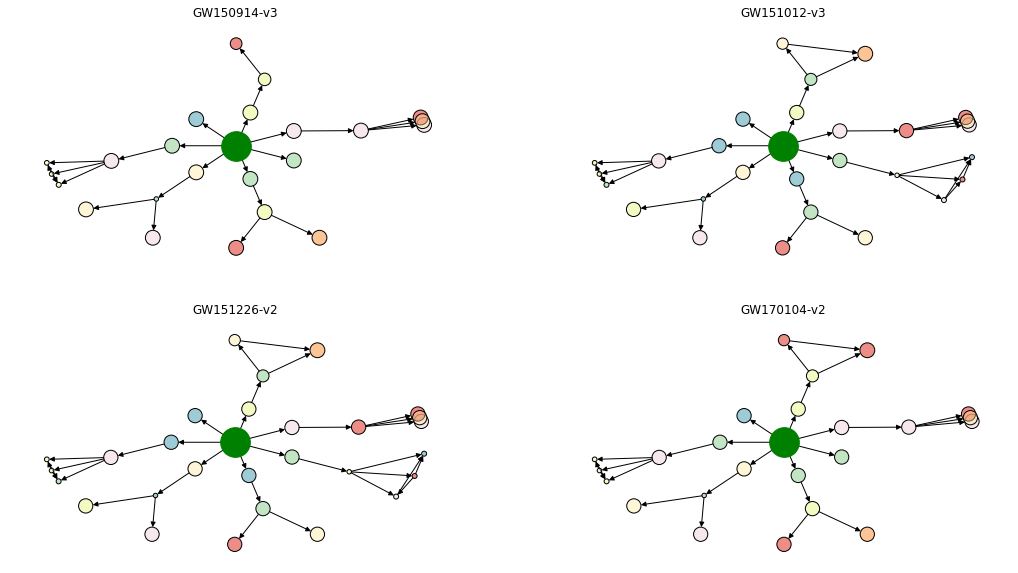

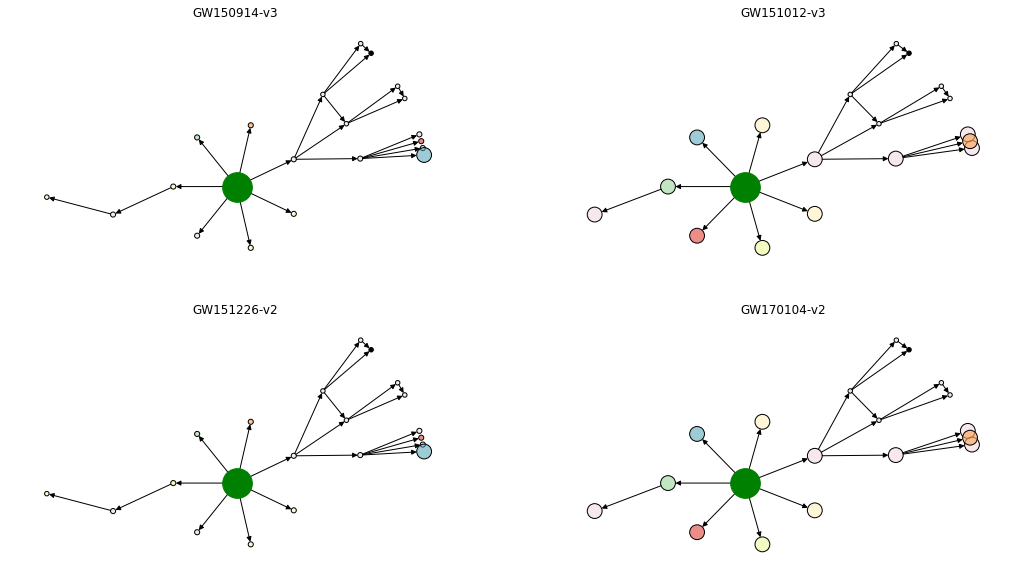

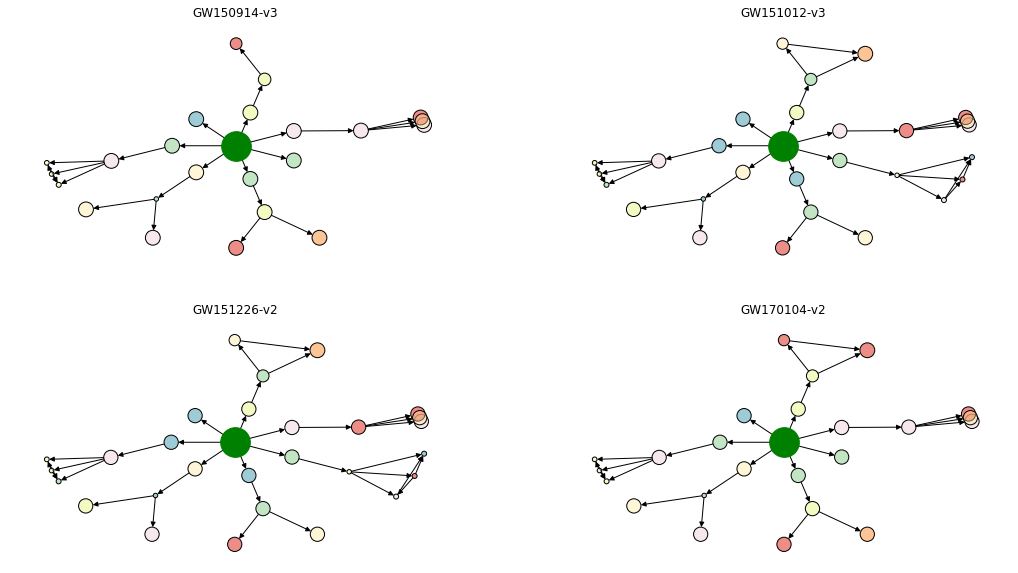

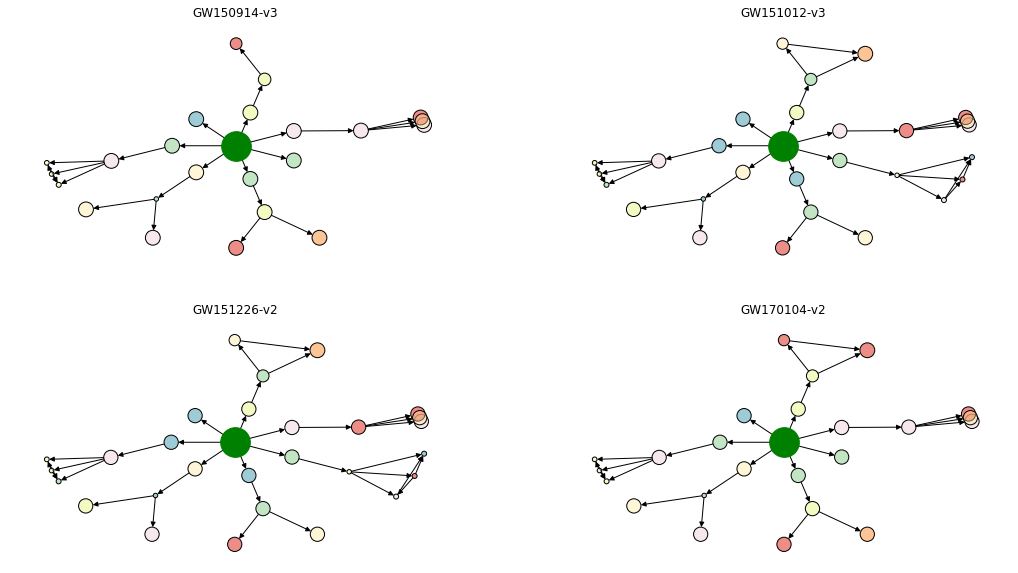

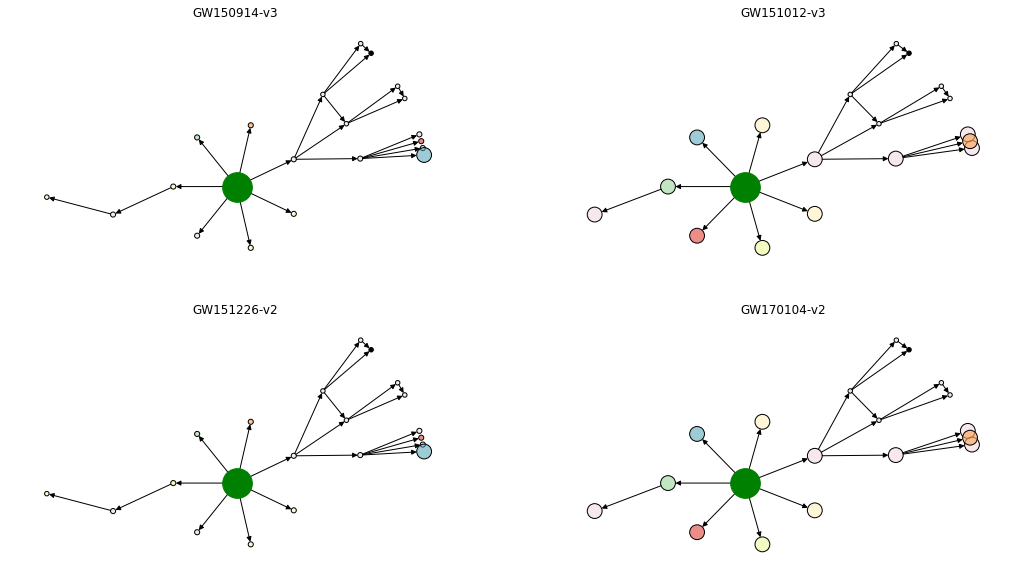

In [13]:
subsets = [ ("Neutron Star", filter_ns(df),y_train.str.contains("Neutron Star"), y_test.str.contains("Neutron Star")),
            ("Black Hole", filter_bh(df),y_train.str.contains("Black Hole"), y_test.str.contains("Black Hole")),
            ("All", [True] * len(df), [True] * len(y_train), [True] * len(y_test))]
#subsets = subsets[0]

def print_bold(s):
    print('\033[1m' + s + '\033[0m')
    
def show_models(pipeline, title, filename, processed_df, alldf, hft, n=4):
    subset_df = alldf
    rkmodels = make_n_rkmodels(processed_df, alldf,hft, pipeline, n=n, indexes=range(0,len(alldf)))
    print_bold("Processed {} rk models from {}".format(len(rkmodels), len(processed_df)))
    mdist = compute_distance(processed_df)
    distances = compute_distances(rkmodels, mdist, w=[.5,.5])
    visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
    #plt.savefig("rendered/untuned_{}_{}.png".format(filename, n))
    #plt.show()
    print_bold("Average similarity {}: {}".format(title, 1 - np.mean(distances)))
    
for s in subsets:
    print_bold("Working on subset " + s[0])
    pdf2 = processed_df[s[1]]
    df2 = df[s[1]]
    f, l = make_linkers_and_filters(g, {})
    untuned_pipeline = RKPipeline(filter_map=f, linkage_map=l, structural_graph=g)
    show_models(untuned_pipeline, "Untuned + No Domain Expertise ", s[0] + "_untuned_no_domain_expertise", processed_df=pdf2, alldf=df2, hft=hft )
    pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
    show_models(pipeline, "Untuned + Domain Expertise", s[0] + "_untuned_domain_expertise", processed_df=pdf2, alldf=df2, hft=hft )
    show_models(pipeline.remap(weights, w0[1]),  "Tuned + Domain Expertise", s[0] + "_tuned_domain_expertise", processed_df=pdf2, alldf=df2, hft=hft )


## Embedding

This is a quick and dirty way to embed an RK Diagram into space.

1. Get positions of TSNE embedding.
2. Impose in some 2D space RK-Diagrams, giving ND representations.

In [148]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

import numpy as np

X_embedded = TSNE(n_components=2,
                   init='random', perplexity=3).fit_transform(processed_df.astype(np.float64))
X_embedded = MinMaxScaler().fit_transform(X_embedded)

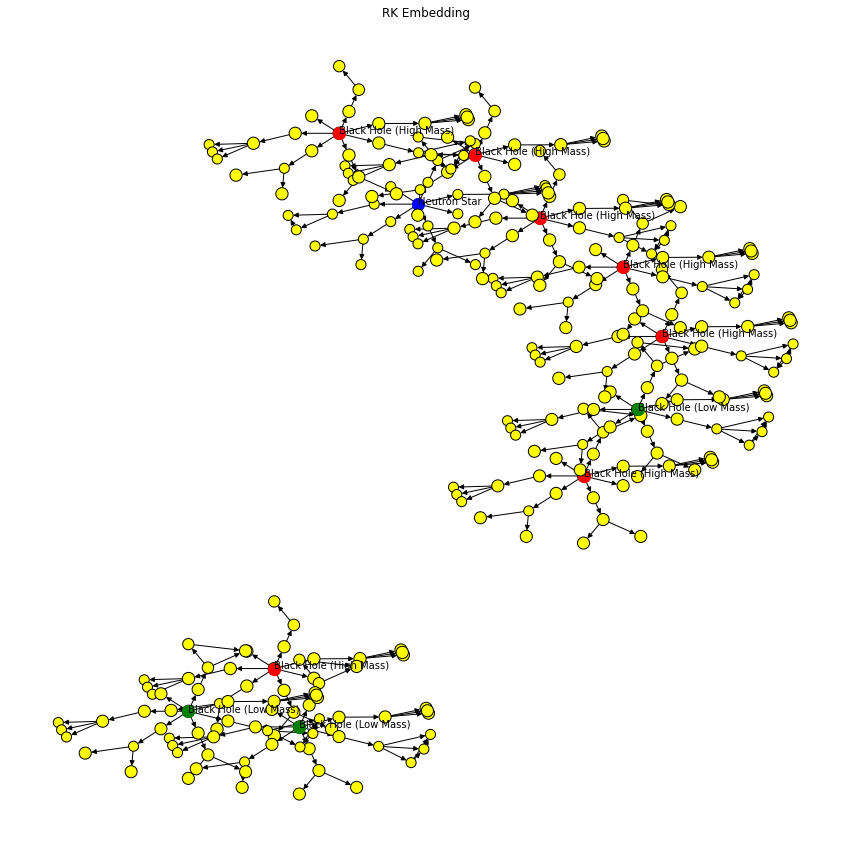

In [157]:
fig, ax = plt.subplots(figsize=(15,15))
from sklearn import preprocessing
le = preprocessing.LabelEncoder().fit_transform(y)
colors = ["red", "green", "blue", "orange"]
for i,r in enumerate(X_embedded): 
    if i > 10:
        break
    base = hft.transform(processed_df.iloc[i])
    rkm = pipeline.transform(base, is_base=False)
    draw_rk_diagram2(rkm, ax=ax, with_labels=False,spread=2, color_override="yellow", center_color=colors[le[i]], xoff=r[0]*300, yoff=r[1]*300, minsize=100, alpha=50, emult=1, make_axis=False)  
    ax.text(r[0]*300, r[1]*300, y[i])
plt.title("RK Embedding")
plt.show()
        

In [153]:
import math 
def draw_rk_diagram2(rkmodel, ax=None, with_labels=True, minsize=100, center_color='green', spread=1,
                    alpha=300, emult=2, make_axis=False, width=2*math.pi, xoff=0, yoff=0, color_override=None):
    if make_axis:
        fig, ax = plt.subplots(figsize=(10,10))

    if ax is None:
        ax = plt.gca()

    # structural pos
    structural_pos = hierarchy_pos(rkmodel.G, 'root', width = width, xcenter=0)
    structural_pos = {u:(r*math.cos(theta)*spread,r*math.sin(theta)*spread) for u, (theta, r) in structural_pos.items()}
    structural_colors = [ n[1].get('color', 'black') for n in list(rkmodel.G.nodes.items())]

    # filter nodes
    rkgraph = rkmodel.get()
    filtered_pos = {k: structural_pos[k]  for k in list(rkgraph.nodes)}

    for k,v in filtered_pos.items():
        filtered_pos[k] = [v[0]+xoff, v[1]+yoff]

    # get indexes
    arr, nodes = [], list(rkgraph.nodes)
    for i, n in enumerate(list(rkmodel.G.nodes)):
        if n in nodes:
            arr.append(i)

    filtered_colors = [structural_colors[i] for i in arr]

    sizes = []
    for n in list(rkgraph.nodes.items()):
        v = n[1].get("value", 1)
        if not isinstance(v, numbers.Number):
            v = 1
        v+=1
        sizes.append(v)

    sizes = np.array(sizes)
    sizes = sizes ** 5 #np.exp(sizes)
    sizes = (sizes - sizes.min()) / (sizes.max()-sizes.min())
    sizes *= alpha
    sizes += minsize
    sizes = np.where(np.isnan(sizes), minsize, sizes)
    if color_override is not None:
        if isinstance(color_override, str):
            filtered_colors = [color_override] * len(filtered_colors)
    nx.draw(rkgraph, pos=filtered_pos, with_labels=with_labels,
            font_size=10, node_size=sizes, ax=ax, node_color = filtered_colors, edgecolors = 'black')

    nx.draw_networkx_nodes(rkgraph, pos=filtered_pos, nodelist = ['root'],
                           node_color = center_color, ax=ax, node_size = sizes.max()*emult)
